# Practica Whatsapp

## Importar

In [1]:
# %load basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('/home/ef/Documents/Diplomado/data/Naps.txt',
                 sep = ',-:',
                 header = None,
                 engine = 'python')
df.sample(4)

,0
4571,"4/4/20, 22:18 - Kevin Bacon: Jardon es rifado"
30615,"8/9/20, 20:05 - Kevin Bacon: ."
38581,"10/9/20, 18:15 - Kevin Bacon: Jajajajaja anda ..."
33544,"8/23/20, 20:25 - Iván Jardón: Si me compro el ..."


In [3]:
## Se construye una tabla semi-estructurada
aux1 = df[0].str.split(',', n = 1, expand = True).copy()
df['Fecha'] = aux1[0]

aux2 = aux1[1].str.split('-',n = 1, expand = True).copy()
df['Hora'] = aux2[0]

aux3 = aux2[1].str.split(':',n = 1, expand = True).copy()
df['Autor'] = aux3[0]
df['Mensaje'] = aux3[1]
df = df.iloc[:,1:].copy()
df.sample(4)

,Fecha,Hora,Autor,Mensaje
33655,8/24/20,11:03,EF,Jajajaja
6986,4/23/20,14:32,Iván Jardón,Ayúdala tu entonces
39537,10/18/20,14:14,Kevin Bacon,"Los tuyos también, brob"
11508,5/16/20,16:27,Kevin Bacon,Luego averiguan por qué


## Limpieza

### Autores

In [4]:
## Sólo hay tres integrantes en el grupo de chat
df['Autor'].value_counts(1)

 Kevin Bacon                                                                                      0.397950
 Iván Jardón                                                                                      0.353325
 EF                                                                                               0.248250
 Iván Jardón changed their phone number to a new number. Tap to message or add the new number.    0.000050
 Iván Jardón added Kevin Bacon                                                                    0.000050
 Kevin Bacon left                                                                                 0.000050
 Kevin Bacon changed the subject from "Naps 🐻🐼🐔" to "Naps 🐻🐼🐯"                                    0.000050
 You changed this group's icon                                                                    0.000025
 Iván Jardón changed the subject from "Naps 🐻🐼🐯" to "Naps 🐻🐼🐔"                                    0.000025
 Kevin Bacon changed the subject from

In [5]:
## Se despliegan las posibles opciones para cada variable categórica,
# agrupando las categorías con menos del 1% de frecuencia
cat = ['Autor']
adj = []
for col in cat:
    aux = []
    aux = df[col].value_counts(1, dropna = False).reset_index()
    global adj
    for i in range(len(aux)):
        if aux.iloc[i,1] < .01:
            adj.append(aux.iloc[i,0])
df[cat] = df[cat].replace(adj, 'Otros')

for col in cat:
    display(df[col].value_counts(1).reset_index())

,index,Autor
0,Kevin Bacon,0.396700
1,Iván Jardón,0.352216
2,EF,0.247470
3,Otros,0.003614


In [6]:
df = df[df['Autor'] != 'Otros'].copy()
df['Autor'].value_counts(1)

 Kevin Bacon    0.398139
 Iván Jardón    0.353493
 EF             0.248368
Name: Autor, dtype: float64

### Fecha y hora

<AxesSubplot:>

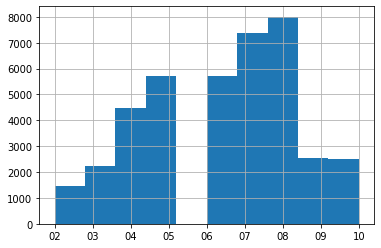

In [7]:
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Mes'] = [x.strftime('%m') for x in df['Fecha']]
df['Mes'].hist()

<AxesSubplot:>

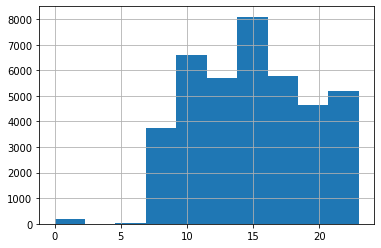

In [8]:
df['hora_solo'] = [int(x.strip()[:2]) for x in df['Hora']]
df['hora_solo'].hist()

array([[<AxesSubplot:title={'center':'hora_solo'}>]], dtype=object)

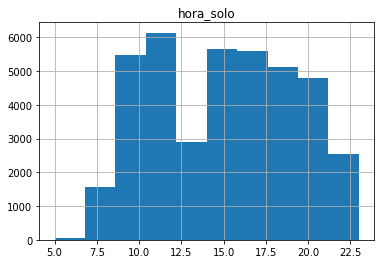

In [9]:
## Función para omitir outliers mediante IQR
def outlier(data, x, how = 'both', p = 0.6):
    for i in x:
        var = data[i]
        q1 = var.quantile(p/2) #acota el % indicado, tanto máx como mín
        q3 = var.quantile(1 - p/2)
        iqr = q3 - q1

        if how == 'max':
            data = data[(var.isnull()) | (var <= q3 + 1.5*iqr)].copy() #no debemos eliminar nulos
        elif how == 'min':
            data = data[(var.isnull()) | (var >= q1 - 1.5*iqr)].copy()
        elif how == 'both':
            data = data[(var.isnull()) | ((var >= q1 - 1.5*iqr) & (var <= q3 + 1.5*iqr))].copy()
        else:
            print('¿Cómo quieres acotar outliers? how = min/max/both')

        data.reset_index(drop = True, inplace = True)
        global df
        df = data.copy()

num = ['hora_solo']
outlier(df,num)
df[num].hist()

<AxesSubplot:>

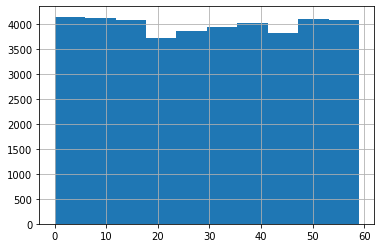

In [10]:
df['minutos'] = [int(x.strip()[3:]) for x in df['Hora']]
df['minutos'].hist()

### Mensaje

In [11]:
df['Mensaje'].value_counts(1)

 <Media omitted>                                       0.117251
 Jajajaja                                              0.024616
 Jajaja                                                0.015096
 Jajajajaja                                            0.013388
 .                                                     0.007134
                                                         ...   
 En ese momento, no todo el tiempo como acostumbras    0.000025
 Igual, no hay dolor ni nada, entonces cool            0.000025
 Cogerte un culito *                                   0.000025
 Así pasa siempre                                      0.000025
 Siiii!                                                0.000025
Name: Mensaje, Length: 25545, dtype: float64

In [12]:
## Función para limpiar mensajes
import unicodedata
import re

def limpiar_texto(text, pattern ='[^a-zA-Z0-9 ]'):
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, ' ', cleaned_text.decode('utf-8'), flags = re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().split())
    return cleaned_text

df['Mensaje_limpio'] = df['Mensaje'].map(limpiar_texto)
df['Mensaje_limpio'].value_counts(1).head(13)

media omitted       0.117251
jajajaja            0.025972
                    0.025168
jajaja              0.015372
jajajajaja          0.014594
jajajajajaja        0.007008
jajajajajajaja      0.004245
jalo                0.003140
x2                  0.003064
si                  0.002838
no                  0.002311
jaja                0.002286
jajajajajajajaja    0.002160
Name: Mensaje_limpio, dtype: float64

In [13]:
## Juntar 'jajaja's
aux = []
for x in df['Mensaje_limpio']:
    if (x.startswith('ja') | x.startswith('aj') | x.startswith('jj') | x.startswith('aa')) & (x.endswith('ja') | x.endswith('aj') | x.endswith('jj') | x.endswith('aa')):
        aux.append('jaja')
    else:
        aux.append(x)
df['Mensaje_limpio'] = aux
df['Mensaje_limpio'].value_counts(1).head(13)

media omitted               0.117251
jaja                        0.106752
                            0.025168
jalo                        0.003140
x2                          0.003064
si                          0.002838
no                          0.002311
no we                       0.002160
mames                       0.002009
simon                       0.001683
gpi                         0.001633
a webo                      0.001608
this message was deleted    0.001582
Name: Mensaje_limpio, dtype: float64

## Ingeniería de variables

### Numéricas

In [14]:
df['num_palabras'] = df['Mensaje_limpio'].str.split(' ').str.len()
df['num_caracteres'] = df['Mensaje'].str.strip().str.len()
df['num_letras'] = df['Mensaje_limpio'].map(lambda x:sum(map(str.isalpha, x)))
df['num_minus_letras'] = df['Mensaje'].map(lambda x:sum(map(str.islower,
                                                                   x))) / df['num_letras']
df['num_mayus_letras'] = df['Mensaje'].map(lambda x:sum(map(str.isupper,
                                                                   x))) / df['num_letras']
df.isnull().sum() / len(df)

Fecha               0.000000
Hora                0.000000
Autor               0.000000
Mensaje             0.000000
Mes                 0.000000
hora_solo           0.000000
minutos             0.000000
Mensaje_limpio      0.000000
num_palabras        0.000000
num_caracteres      0.000000
num_letras          0.000000
num_minus_letras    0.027354
num_mayus_letras    0.027354
dtype: float64

In [15]:
df = df.fillna(0).copy()
df.isnull().sum() / len(df)

Fecha               0.0
Hora                0.0
Autor               0.0
Mensaje             0.0
Mes                 0.0
hora_solo           0.0
minutos             0.0
Mensaje_limpio      0.0
num_palabras        0.0
num_caracteres      0.0
num_letras          0.0
num_minus_letras    0.0
num_mayus_letras    0.0
dtype: float64

<AxesSubplot:>

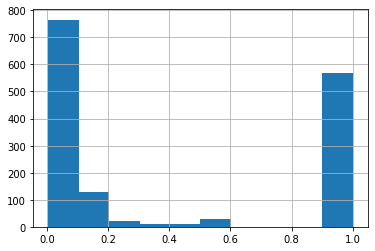

In [16]:
import emoji
df['proporcion_emojis'] = df['Mensaje'].map(emoji.emoji_count) / df['num_caracteres']
## Hay mensajes que sólo son emojis
df[df['proporcion_emojis'] > 0]['proporcion_emojis'].hist()

array([[<AxesSubplot:title={'center':'hora_solo'}>,
        <AxesSubplot:title={'center':'num_palabras'}>],
       [<AxesSubplot:title={'center':'num_caracteres'}>,
        <AxesSubplot:title={'center':'num_letras'}>],
       [<AxesSubplot:title={'center':'num_minus_letras'}>,
        <AxesSubplot:title={'center':'num_mayus_letras'}>]], dtype=object)

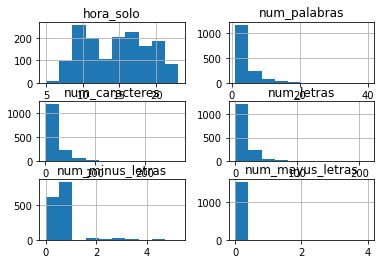

In [17]:
num += [col for col in df.columns if col.startswith('num')]
display(df[df['proporcion_emojis'] > 0][num].hist())

array([[<AxesSubplot:title={'center':'hora_solo'}>,
        <AxesSubplot:title={'center':'num_palabras'}>],
       [<AxesSubplot:title={'center':'num_caracteres'}>,
        <AxesSubplot:title={'center':'num_letras'}>],
       [<AxesSubplot:title={'center':'num_minus_letras'}>,
        <AxesSubplot:title={'center':'num_mayus_letras'}>]], dtype=object)

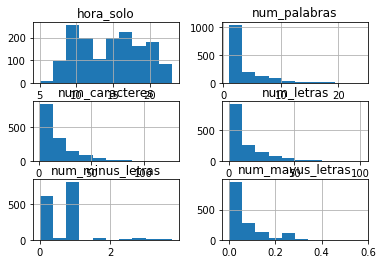

In [18]:
## Sin outliers
outlier(df,num, p = 0.1)
df[df['proporcion_emojis'] > 0][num].hist()

### Categóricas

In [19]:
df['proporcion_emojis'].value_counts(1)

0.000000    0.961407
1.000000    0.014517
0.100000    0.001227
0.083333    0.001150
0.062500    0.000946
              ...   
0.011111    0.000026
0.012346    0.000026
0.078947    0.000026
0.009615    0.000026
0.010526    0.000026
Name: proporcion_emojis, Length: 151, dtype: float64

In [20]:
## El mensaje es imagen/sticker/video/...?
aux = []
for x in df['Mensaje_limpio']:
    if x == 'media omitted':
        aux.append(1)
    else:
        aux.append(0)

df['media'] = aux
df['media'].value_counts(1)

0    0.880693
1    0.119307
Name: media, dtype: float64

In [21]:
## El mensaje tiene emojis o incluso sólo son emojis?
aux = []
col = df['proporcion_emojis']
for x in range(len(col)):
    if col[x] == 1:
        aux.append('emoji')
    elif col[x] > 0:
        aux.append('mixto')
    elif df['media'][x] == 1:
        aux.append('media')
    else:
        aux.append('texto')

df['tipo'] = aux
df['tipo'].value_counts(1)

texto    0.842100
media    0.119307
mixto    0.024076
emoji    0.014517
Name: tipo, dtype: float64

In [22]:
## Crear 5 categorías de rango horario
aux = pd.DataFrame(df['hora_solo'].value_counts(1).sort_index())
aux.cumsum()

,hora_solo
5,0.000179
6,0.001099
7,0.006952
8,0.040485
9,0.095614
10,0.177503
11,0.261028
12,0.331698
13,0.404514
14,0.468972


In [23]:
aux = []
for x in df['hora_solo']:
    if x < 11:
        aux.append('00-10')
    elif x < 14:
        aux.append('11-13')
    elif x < 17:
        aux.append('14-16')
    elif x < 20:
        aux.append('17-19')
    else:
        aux.append('20-24')

df['hora_rango'] = aux
df['hora_rango'].value_counts(1).sort_index()

00-10    0.177503
11-13    0.227010
14-16    0.203190
17-19    0.207841
20-24    0.184455
Name: hora_rango, dtype: float64

In [24]:
## Día de la semana
df['dia_sem'] = [x.weekday() + 1 for x in df['Fecha']]

df['dia_sem'].value_counts(1)

2    0.178066
5    0.169734
4    0.158514
3    0.156213
1    0.134872
6    0.107218
7    0.095384
Name: dia_sem, dtype: float64

In [25]:
## Mensajes seguidos del mismo autor
aux = []
cont = 1
for x in range(len(df)):
    if x == 0:
        aux.append(1)
    else:
        if df['Autor'][x] == df['Autor'][x - 1]:
            cont += 1
            aux.append(cont)
        else:
            cont = 1
            aux.append(1)
df['msj_seguidos'] = aux
df['msj_seguidos'].value_counts(1)

1     0.546823
2     0.264172
3     0.111358
4     0.045034
5     0.018249
6     0.007540
7     0.003169
8     0.001712
9     0.000869
10    0.000511
11    0.000307
13    0.000077
12    0.000077
15    0.000051
14    0.000051
Name: msj_seguidos, dtype: float64

In [26]:
## Etiqueta para el último mensaje enviado por autor,
aux = []
for i in range(len(df)):
    if i >= len(df) - 1:
        aux.append(1)
    else:
        if df['msj_seguidos'][i + 1] == 1:
            aux.append(1)
        else:
            aux.append(0)

df['max_msj'] = aux
df['max_msj'].value_counts(1)

## Se filtran sólo los últimos mensajes por autor
df = df[df['max_msj'] == 1].copy().reset_index(drop = True)

<AxesSubplot:>

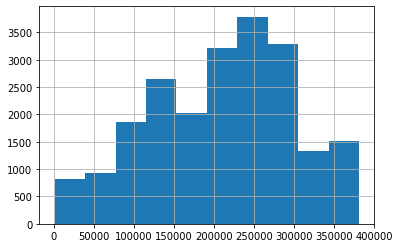

In [27]:
## Diferencia de minutos respecto al primer mensaje

## Cardinalidad de los días en el conjunto
dia_min = df['Fecha'].min()
df['dia'] = [x - dia_min for x in df['Fecha']]
df['dia'] = df['dia'].dt.days.astype(int)

## Cardinalidad de minuto entre todo el conjunto
df['tiempo'] = 24*60*df['dia'] + 60*df['hora_solo'] + df['minutos']
df['tiempo'].hist()

In [28]:
## Diferencia vs el registro anterior
df['dif_minutos'] = df['tiempo'] - df.sort_values(by=['Fecha','tiempo'],
                                                  ascending = True)['tiempo'].shift(1)
df['dif_minutos'] = df['dif_minutos'].fillna(0).copy()
df['dif_minutos'].head(6)

0       0.0
1       1.0
2    2236.0
3       5.0
4       1.0
5       3.0
Name: dif_minutos, dtype: float64

In [29]:
df.head(6)

,Fecha,Hora,Autor,Mensaje,Mes,hora_solo,minutos,Mensaje_limpio,num_palabras,num_caracteres,...,proporcion_emojis,media,tipo,hora_rango,dia_sem,msj_seguidos,max_msj,dia,tiempo,dif_minutos
0,2020-02-03,19:51,Kevin Bacon,Ni mergas,02,19,51,ni mergas,2,9,...,0.0,0,texto,17-19,1,1,1,0,1191,0.0
1,2020-02-03,19:52,Iván Jardón,Eso es todo lo que quería escuchar,02,19,52,eso es todo lo que queria escuchar,7,34,...,0.0,0,texto,17-19,1,2,1,0,1192,1.0
2,2020-02-05,09:08,EF,Cómo van mis sandwiches?,02,9,8,como van mis sandwiches,4,24,...,0.0,0,texto,00-10,3,1,1,2,3428,2236.0
3,2020-02-05,09:13,Iván Jardón,Creo que la he cagado,02,9,13,creo que la he cagado,5,21,...,0.0,0,texto,00-10,3,2,1,2,3433,5.0
4,2020-02-05,09:14,EF,No desesperes,02,9,14,no desesperes,2,13,...,0.0,0,texto,00-10,3,2,1,2,3434,1.0
5,2020-02-05,09:17,Iván Jardón,Ptm,02,9,17,ptm,1,3,...,0.0,0,texto,00-10,3,6,1,2,3437,3.0


### Variable objetivo

In [30]:
df['vistus'] = df['dif_minutos'] > 5
df['vistus'] = df['vistus'].astype(int)
df['vistus'].value_counts(1)

0    0.825099
1    0.174901
Name: vistus, dtype: float64

## Regresión logística

### Reducción de dimensiones

In [31]:
df.columns

Index(['Fecha', 'Hora', 'Autor', 'Mensaje', 'Mes', 'hora_solo', 'minutos',
       'Mensaje_limpio', 'num_palabras', 'num_caracteres', 'num_letras',
       'num_minus_letras', 'num_mayus_letras', 'proporcion_emojis', 'media',
       'tipo', 'hora_rango', 'dia_sem', 'msj_seguidos', 'max_msj', 'dia',
       'tiempo', 'dif_minutos', 'vistus'],
      dtype='object')

In [32]:
num += ['minutos', 'proporcion_emojis', 'dia', 'tiempo']
df[num].describe()

,hora_solo,num_palabras,num_caracteres,num_letras,num_minus_letras,num_mayus_letras,minutos,proporcion_emojis,dia,tiempo
count,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000
mean,14.972564,3.975976,21.117457,16.862772,0.959396,0.104042,29.366020,0.019331,145.125076,209907.829212
std,4.176590,3.444288,17.663868,14.219031,0.397794,0.088221,17.516227,0.130529,61.821340,89014.985881
min,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1191.000000
25%,11.000000,2.000000,10.000000,8.000000,0.888889,0.047619,14.000000,0.000000,97.000000,140616.000000
50%,15.000000,3.000000,15.000000,12.000000,0.923077,0.083333,29.000000,0.000000,151.000000,218167.000000
75%,18.000000,5.000000,27.000000,22.000000,0.958333,0.125000,45.000000,0.000000,187.000000,270168.500000
max,23.000000,26.000000,135.000000,109.000000,4.000000,0.600000,59.000000,1.000000,264.000000,381022.000000


In [33]:
for x in num:
    min_num = df[x].min()
    max_num = df[x].max()
    rango = max_num - min_num
    df[f'{x}_nor'] = (df[x] - min_num) / rango

num_nor = [col for col in df.columns if col.endswith('nor')]
df[num_nor].describe()

,hora_solo_nor,num_palabras_nor,num_caracteres_nor,num_letras_nor,num_minus_letras_nor,num_mayus_letras_nor,minutos_nor,proporcion_emojis_nor,dia_nor,tiempo_nor
count,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000,21395.000000
mean,0.554031,0.119039,0.150130,0.154704,0.239849,0.173403,0.497729,0.019331,0.549716,0.549499
std,0.232033,0.137772,0.131820,0.130450,0.099449,0.147035,0.296885,0.130529,0.234172,0.234354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.040000,0.067164,0.073394,0.222222,0.079365,0.237288,0.000000,0.367424,0.367071
50%,0.555556,0.080000,0.104478,0.110092,0.230769,0.138889,0.491525,0.000000,0.571970,0.571244
75%,0.722222,0.160000,0.194030,0.201835,0.239583,0.208333,0.762712,0.000000,0.708333,0.708150
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
cat = [col for col in df.iloc[:,7:].columns if col not in num + num_nor + ['dif_minutos',
                                                                           'media',
                                                                           'vistus']]
cat

['Mensaje_limpio', 'tipo', 'hora_rango', 'dia_sem', 'msj_seguidos', 'max_msj']

In [35]:
## Se vectoriza el mensaje limpio, se limpian las palabras
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = TfidfVectorizer(ngram_range = (1, 1),
                     min_df = 10,
                     max_features = 100)
cv.fit(df['Mensaje_limpio'])

## Se crea nuestra matriz de variables numéricas (normalizadas) y las categóricas como dummies
num = num_nor
X = df[num].join(pd.get_dummies(df[cat]))
## Se crea la matriz en donde cada palabra es una columna (estilo dummy)
aux = pd.DataFrame(data = cv.transform(df['Mensaje_limpio']).todense(),
                   columns = cv.get_feature_names()).reset_index()
X = X.reset_index().merge(aux, on = 'index', how = 'left')
## Se define la variable objetivo
y = df['vistus']

## Se eligirán las mejores variables
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
kb = SelectKBest(k = 9, score_func = f_regression)
kb.fit(X, y)

ls_best = [x for x, y in zip(X.columns, kb.get_support()) if y]
ls_best

/home/ef/Desktop/diplomadus/diplomadus/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/ef/Desktop/diplomadus/diplomadus/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


['num_palabras_nor',
 'msj_seguidos',
 'Mensaje_limpio_media omitted',
 'tipo_media',
 'tipo_texto',
 'media',
 'no',
 'omitted',
 'pero']

In [36]:
## Y se actualiza nuestra matriz de variables a sólo esas
X = X[ls_best]

## Se hace la partición del conjunto de entrenamiento y de prueba
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Modelaje

In [37]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
ls_scores = cross_val_score(X = X_train,
                            y = y_train,
                            cv = 4,
                            estimator = logreg,
                            scoring = 'roc_auc')
## Se observa la acertividad en 4 diferentes secciones del conjunto de entrenamiento
np.mean(ls_scores), np.std(ls_scores)

(0.6698533514662179, 0.009746860536869734)

In [38]:
## La acertividad en el conjunto de prueba es subjetivamente confiable
'{:,.2%}'.format(logreg.score(X_test, y_test))

'82.28%'

In [39]:
## Se despliega la relación que tiene cada una de las mejores variables que explican
# la variable objetivo
pd.DataFrame(list(zip(ls_best, logreg.coef_[0])),
            columns = ['Variable', 'Explica_vistus']).sort_values(by = 'Explica_vistus')

,Variable,Explica_vistus
8,pero,-1.656394
6,no,-0.422328
4,tipo_texto,-0.173159
5,media,0.163022
0,num_palabras_nor,0.197556
1,msj_seguidos,0.213924
7,omitted,0.335492
2,Mensaje_limpio_media omitted,0.474353
3,tipo_media,0.474353


In [40]:
## Se preserva el modelo
pd.to_pickle(logreg, 'logreg.diplo')

## Regresión lineal

In [41]:
## Respaldo de tabla limpia
df_respaldo = df.copy()

In [42]:
df = df_respaldo.copy()

### Reducción de dimensiones

In [43]:
## Se quiere conocer
df = df_respaldo.copy()
df = pd.pivot_table(df,
                    index = ['Fecha', 'hora_rango', 'dia_sem'],
                    columns = 'Autor',
                    values = 'Mensaje',
                    aggfunc = 'count').copy().reset_index()
df.fillna(0, inplace = True)
df.sample(4)

Autor,Fecha,hora_rango,dia_sem,EF,Iván Jardón,Kevin Bacon
789,2020-08-25,17-19,2,30.0,34.0,32.0
753,2020-08-18,11-13,2,6.0,7.0,5.0
72,2020-03-04,17-19,3,0.0,2.0,1.0
466,2020-06-17,17-19,3,25.0,19.0,18.0


<AxesSubplot:>

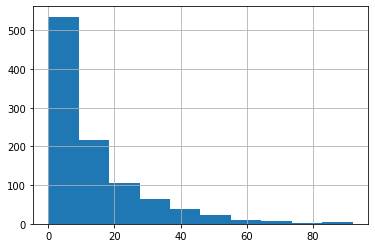

In [45]:
objetivo = ' Kevin Bacon'
resto = [col for col in df.iloc[:,-3:].columns if col not in objetivo]

df['sum_chat'] = df[resto[0]] + df[resto[1]]
df['sum_chat'].hist()

<AxesSubplot:>

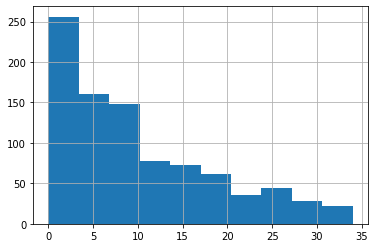

In [45]:
outlier(df,['sum_chat'])
df['sum_chat'].hist()

In [46]:
variables = df.iloc[:,2:].columns

X = df[[x for x in variables if x not in objetivo]].join(pd.get_dummies(df['hora_rango']))
y = df[objetivo]

## Se eligirán las mejores variables
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
kb = SelectKBest(k = 9, score_func = f_regression)
kb.fit(X, y)

ls_best = [x for x, y in zip(X.columns, kb.get_support()) if y]
ls_best

['dia_sem',
 ' EF',
 ' Iván Jardón',
 'sum_chat',
 '00-10',
 '11-13',
 '14-16',
 '17-19',
 '20-24']

In [47]:
X = X[ls_best]
X.head(4).join(y.head(4))

,dia_sem,EF,Iván Jardón,sum_chat,00-10,11-13,14-16,17-19,20-24,Kevin Bacon
0,1,0.0,1.0,1.0,0,0,0,1,0,1.0
1,3,6.0,8.0,14.0,1,0,0,0,0,7.0
2,3,4.0,1.0,5.0,0,1,0,0,0,3.0
3,3,1.0,0.0,1.0,0,0,0,1,0,2.0


In [48]:
from sklearn.linear_model import LinearRegression, Lars, ElasticNet, Lasso, Ridge, BayesianRidge
linreg = LinearRegression()
linreg.fit(X, y)
ls_res = cross_val_score(estimator = linreg,
                         X = X,
                         y = y,
                         cv = 4,
                         n_jobs = -1,
                         scoring='r2')
np.mean(ls_res), np.std(ls_res)

(0.7320673195015495, 0.03180897363280953)

In [49]:
ls_res

array([0.72186575, 0.74729855, 0.6865494 , 0.77255558])

In [50]:
## Se despliega la relación que tiene cada una de las mejores variables que explican
# la variable objetivo
pd.DataFrame(list(zip(df.columns, linreg.coef_)),
            columns = ['Variable', 'Explica_texto']).sort_values(by = 'Explica_texto')

,Variable,Explica_texto
6,sum_chat,-0.120697
0,Fecha,-0.096343
1,hora_rango,0.155645
4,Iván Jardón,0.180547
2,dia_sem,0.210477
5,Kevin Bacon,0.317739
3,EF,0.366122


In [51]:
## Se crea diccionario para consolidar resultados
dc_scores = {}
dc_scores.update({str(linreg).split('(')[0]: np.mean(ls_res)})
dc_scores

{'LinearRegression': 0.7320673195015495}

### LARS

In [52]:
larsreg = Lars()
larsreg.fit(X, y)
ls_res = cross_val_score(estimator = larsreg,
                         X = X,
                         y = y,
                         cv = 4,
                         n_jobs = -1,
                         scoring = 'r2')
np.mean(ls_res), np.std(ls_res)

(0.7320673195015504, 0.03180897363281)

In [53]:
## Se despliega la relación que tiene cada una de las mejores variables que explican
# la variable objetivo
pd.DataFrame(list(zip(variables, larsreg.coef_)),
            columns = ['Variable', 'Explica_texto']).sort_values(by = 'Explica_texto')

,Variable,Explica_texto
0,dia_sem,-0.096343
1,EF,0.000000
2,Iván Jardón,0.054831
4,sum_chat,0.254730
3,Kevin Bacon,0.521767


In [54]:
dc_scores.update({str(larsreg).split('(')[0]: np.mean(ls_res)})
dc_scores

{'LinearRegression': 0.7320673195015495, 'Lars': 0.7320673195015504}

### Ridge

In [55]:
## Se prueba con diferentes valores de alpha
aux = []
for i in range(0, 1000, 5):
    ridgereg = Ridge(alpha = i)
    ridgereg.fit(X, y)
    ls_res = cross_val_score(estimator = ridgereg,
                             X = X,
                             y = y,
                             cv = 4,
                             n_jobs = -1,
                             scoring = 'r2')
    aux.append(np.mean(ls_res))
aux = pd.DataFrame(aux, 
                  columns = ['R2']).reset_index()

## Se escoge la mejor alpha
R2 = 0
for x in range(len(aux)):
    if aux['R2'][x] > R2:
        R2 = aux['R2'][x]
        alpha = aux['index'][x]

## Y se muestra la media y varianza de la validación cruzada con la mejor alpha
ridgereg = Ridge(alpha = alpha)
ridgereg.fit(X, y)
ls_res = cross_val_score(estimator = ridgereg,
                         X=X,
                         y=y,
                         cv=4,
                         n_jobs = -1,
                         scoring='r2')
np.mean(ls_res), np.std(ls_res)

(0.7330491898904268, 0.032652813496317386)

In [56]:
## Se despliega la relación que tiene cada una de las mejores variables que explican
# la variable objetivo
pd.DataFrame(list(zip(variables, ridgereg.coef_)),
            columns = ['Variable', 'Explica_texto']).sort_values(by = 'Explica_texto')

,Variable,Explica_texto
0,dia_sem,-0.091348
4,sum_chat,0.098509
1,EF,0.158165
2,Iván Jardón,0.207838
3,Kevin Bacon,0.366003


In [57]:
dc_scores.update({str(ridgereg).split('(')[0]: np.mean(ls_res)})
dc_scores

{'LinearRegression': 0.7320673195015495,
 'Lars': 0.7320673195015504,
 'Ridge': 0.7330491898904268}

### Lasso

In [58]:
## Se prueba con diferentes valores de alpha
aux = []
for i in range(0, 1000, 5):
    lasso = Lasso(alpha = i/100)
    lasso.fit(X, y)
    ls_res = cross_val_score(estimator = lasso,
                             X = X,
                             y = y,
                             cv = 4,
                             n_jobs = -1,
                             scoring = 'r2')
    aux.append(np.mean(ls_res))
aux = pd.DataFrame(aux, 
                  columns = ['R2']).reset_index()

## Se escoge la mejor alpha
R2 = 0
for x in range(len(aux)):
    if aux['R2'][x] > R2:
        R2 = aux['R2'][x]
        alpha = aux['index'][x]

## Y se muestra la media y varianza de la validación cruzada con la mejor alpha
lasso = Lasso(alpha = alpha)
lasso.fit(X, y)
ls_res = cross_val_score(estimator = lasso,
                             X = X,
                             y = y,
                             cv = 4,
                             n_jobs = -1,
                             scoring = 'r2')
np.mean(ls_res), np.std(ls_res)

<ipython-input-58-874fc20bc1c6>:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X, y)
/home/ef/Desktop/diplomadus/diplomadus/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/ef/Desktop/diplomadus/diplomadus/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3397.5667282553864, tolerance: 2.6718028665931626
  model = cd_fast.enet_coordinate_descent(


(0.6028193491440142, 0.03087326249164444)

In [59]:
## Se despliega la relación que tiene cada una de las mejores variables que explican
# la variable objetivo
pd.DataFrame(list(zip(variables, lasso.coef_)),
            columns = ['Variable', 'Explica_texto']).sort_values(by = 'Explica_texto')

,Variable,Explica_texto
0,dia_sem,-0.000000
1,EF,0.000000
2,Iván Jardón,0.000000
4,sum_chat,0.000000
3,Kevin Bacon,0.329167


In [60]:
dc_scores.update({str(lasso).split('(')[0]: np.mean(ls_res)})
dc_scores

{'LinearRegression': 0.7320673195015495,
 'Lars': 0.7320673195015504,
 'Ridge': 0.7330491898904268,
 'Lasso': 0.6028193491440142}

### Regresión Bayesiana

In [61]:
bayreg = BayesianRidge()
bayreg.fit(X, y)
ls_res = cross_val_score(estimator = bayreg,
                         X = X, 
                         y = y, 
                         cv = 4, 
                         n_jobs = -1, 
                         scoring = 'r2')
np.mean(ls_res), np.std(ls_res)

(0.7330146482653148, 0.032607638409276656)

In [62]:
## Se despliega la relación que tiene cada una de las mejores variables que explican
# la variable objetivo
pd.DataFrame(list(zip(variables, bayreg.coef_)),
            columns = ['Variable', 'Explica_texto']).sort_values(by = 'Explica_texto')

,Variable,Explica_texto
0,dia_sem,-0.091952
4,sum_chat,0.105168
1,EF,0.157953
2,Iván Jardón,0.208093
3,Kevin Bacon,0.366046


In [63]:
dc_scores.update({str(bayreg).split('(')[0]: np.mean(ls_res)})
dc_scores

{'LinearRegression': 0.7320673195015495,
 'Lars': 0.7320673195015504,
 'Ridge': 0.7330491898904268,
 'Lasso': 0.6028193491440142,
 'BayesianRidge': 0.7330146482653148}

### Elección de modelo

In [64]:
## Se presenta qué tanto afectan las variables a la variable objetivo
# con los diferentes modelos construidos
resul = pd.DataFrame(columns=[])
alfas = pd.DataFrame(columns=[])
for model in [linreg, larsreg, ridgereg, lasso, bayreg]:
    resul[str(model).split('(')[0]] = model.coef_
    alfas[str(model).split('(')[0]] = [model.intercept_]

resul['features'] = list(X.columns)
resul = resul.set_index('features')
alfas['features'] = ['intercepto']
alfas = alfas.set_index('features')
resul = alfas.append(resul)
display(resul)

,LinearRegression,Lars,Ridge,Lasso,BayesianRidge
features,,,,,
intercepto,0.585067,0.510884,0.567717,2.411723,0.569411
dia_sem,-0.096343,-0.096343,-0.091348,-0.000000,-0.091952
EF,0.155645,0.000000,0.158165,0.000000,0.157953
Iván Jardón,0.210477,0.054831,0.207838,0.000000,0.208093
sum_chat,0.366122,0.521767,0.366003,0.329167,0.366046
00-10,0.180547,0.254730,0.098509,0.000000,0.105168
11-13,0.317739,0.391922,0.168533,0.000000,0.180342
14-16,-0.120697,-0.046514,-0.064918,-0.000000,-0.069364
17-19,-0.303406,-0.229223,-0.165013,-0.000000,-0.176243


In [65]:
## El más acertado es la regresión ridge
display(pd.DataFrame.from_dict(dc_scores,
                       orient = 'index',
                       columns = ['R2']).reset_index().sort_values(by = 'R2',
                                                                  ascending = False))

,index,R2
2,Ridge,0.733049
4,BayesianRidge,0.733015
1,Lars,0.732067
0,LinearRegression,0.732067
3,Lasso,0.602819


In [74]:
## Aplicando el mejor modelo al conjunto de prueba a través de validación cruzada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
model = Ridge()
model.fit(X_train, y_train)
ls_medias = cross_val_score(estimator = model,
                            X = X_test,
                            y = y_test, 
                            cv = 4, 
                            n_jobs = -1, 
                            scoring = 'r2')
'{:,.2%}'.format(np.mean(ls_medias)), '{:,.2%}'.format(np.std(ls_medias))
## Se obtiene una acertividad subjetivamente confiable

('77.87%', '3.42%')